# Project 1, TMA 4320


Our task was to study how an increase in atmospheric $CO_2$ impacts the worlds oceans. This mainly involves studying the concentration of dissolved inorganic carbon, referenced to as DIC.
As a consequence of the oceans massive complexity, we were given a simplified model to work from. Our model describes a one-dimensional column of water, that allows us to look at the concentration of DIC as a function of depth and time. 
We were to study this column from a set of equations and various assumptions given. These assumptions include assuming ideal gas, constant wind speed, immediate dissolvation of $CO_2$ in water and a linear relationship between partial pressure of $CO_2$ and equilibrium concentration of DIC. All equations and constants referenced were taken directly from the assignment text, provided by Tor Nordam $28.01.2021$.

The PDE given by the diffusion-equation was solved by the Crank-Nicolson method, with boundary conditions given by Fick's law. At the surface, the flux is given by $(3)$, and a no-flux boundary is assumed at the sea-floor.

Computation is made for two different scenarios, looking at depths down to $100$ and $4000$ meters respectively, and using two different diffusivity equations. In the first equation, the changes in diffusivity are accounted for by factoring in friction on the seafloor and wind at surface level. 
In the second equation, the usage of a sigmoid function gives a high value diffusivity in the surface mixed layer, and lower values for greater depths.

Presented below is our code for the project with comments to explain our method. Every block of code contains a bit of text to 
clarify the task and how the code works. At the end of our program we have included a discussion dedicated to the results and their meaning. As suggested in the 
project description we have chosen not to include our test cases, but inform that these have been completed in a satisfying manner.

In [1]:
! pip install numba
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from numba import jit
from scipy import integrate
%matplotlib inline

     |████████████████████████████████| 3.2 MB 25.3 MB/s 
     |████████████████████████████████| 25.3 MB 62.5 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


The first block of code is our foundation. It defines essential functions that will be reused 
in both problems. From the assignment description text we implemented the numerical methods presented.

First of we define the functions "consts" that returns a number of useful constants which differ from problem $1$ and $2$. 
Furthermore, we implement our matrices L, R, V and S from equations $(26a), (26b), (27)$ and $(29)$ respectively. One could say that in a larger program one should define only one function per constant/matrix. However this is a relative small program, and since it is not supposed to be used in conjunction with other programs, readability was prioritized.
Taking use of the equation tdma_solver and tdma, we obtain the results in a manner which is easy to deal with later on.

A choice has been made here to represent the S-vector as a matrix in both problem $1$ and problem $2$.
An argument can be made that the S-vector is not time dependent in problem $1$, and that representing it as a constant matrix is not optimal for run-time.
On the other hand, reusing the same function for problem $1$ and $2$ makes it easier to read, in addition to making debugging faster.

The two following equations represent the diffusivity as a function of depth for the two different scenarios.
C_iter allows us to iterate through time and gives the values for our plots.
At last we create a plotting-function to standardize font sizes and ticks per axis.



In [2]:

#Grouping constants into an easily callable function:
def consts(t, dt, z, dz, kw, K):
    alpha = dt/(2*dz**2)
    T = 2*alpha*kw*dz*(1 - (K[1]-K[0])/(2*K[0]))
    #K given from text to create matrices R and L:
    K_ = np.zeros(len(z))
    K_[1:-1] = K[2:] - K[:-2]
    
    return alpha, T, K_

#Connecting definitions of matrices in function:
def createMatrices(t,alpha, K, K_, T, C_eq, N):
    
    #Creates L-matrix
    L_main  = 1 + 2*alpha*K
    L_upper = -(alpha/4)*K_[:-1] - alpha*K[:-1]
    L_lower = (alpha/4)*K_[1:] - alpha*K[1:]
    
    L_main[0] = 1+2*alpha*K[0]+T
    L_upper[0] = -2*alpha*K[0]
    L_lower[-1] = -2*alpha*K[-1]
    L = diags([L_upper, L_main, L_lower], offsets = [1, 0, -1])

    #Creates R-matrix
    R_main  = 1 - 2*alpha*K
    R_upper = (alpha/4)*K_[:-1]+alpha*K[:-1]
    R_lower = -(alpha/4)*K_[1:] + alpha*K[1:]
    
    R_main[0] = 1-2*alpha*K[0]-T
    R_upper[0] = 2*alpha*K[0]
    R_lower[-1] = 2*alpha*K[-1]
    R = diags([R_upper, R_main, R_lower], offsets = [1, 0, -1])

    #Creates S-matrix
    S=np.zeros(shape=(len(t), N))
    for i in range (len(S)):
        S[i][0]=2*T*C_eq[i]

    return L, R, S



#Defining V-vector, with S representing S^(i) and S1 representing S^(i+1) 
def V_vector(R, C, S, S1):
    return R.dot(C) + (1/2)*(S+S1)


#tdma_solver and tdma are functions given by Nordam to solve the equations given in the assignment
#using the Thomas algorithm
@jit(nopython = True)

def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # Shape of A-matrix as 
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b for x
    # This is a wrapper function, that unpacks
    # A from a sparse diagonal matrix into multiple independent diagonals
    # which allows the use of tdma_solver() 

    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x



#Defining the two different functions used to compute the diffusivity as function of depth
#k1 for problem 1 and k2 for problem 2

def k1(z, l):
    k0 = 10**(-3)
    ka= 2*10**(-2)
    kb= 5*10**(-2)
    return k0 + ka*(z/7)*np.exp(-z/7) + kb*((l-z)/10)*np.exp(-(l-z)/10)


def k2(z):
    k0=10**(-4)
    k1=10**(-2)
    a=0.5
    z0=100
    return k1 + (k0-k1)/(1+np.exp(-a*(z-z0)))



#Implementing C_iter which defines C^{i+1} as given by the Crank-Nicolson method (eq.(28)), 
#that is the change in concentrations for each timestep. 
def C_iter(C0, K, t, S, N, L, R):
    C_ = np.zeros(shape = (len(t), N))
    
    C_[0] = C0
    
    for i in range(len(C_)-1):
        V = V_vector(R, C_[i], S[i], S[i+1])
        C_[i+1] = tdma(L,V)
    return C_




#Standardized function to define figuretitles, fontsizes, labels and number of ticks pr. axis

def plot(figTitle, xLabel, yLabel,ybins,xbins):
    plt.title(figTitle, fontsize = 20)
    plt.xlabel(xLabel, fontsize = 16)
    plt.ylabel(yLabel, fontsize = 16)
    plt.locator_params(axis='y', nbins=ybins)
    plt.locator_params(axis='x', nbins=xbins)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

## Problem 1: Response to changing $CO_2$ concentration in shallow areas

The first task is to compute and plot $CO_2$ concentration in a shallow column of ocean water to see whether the DIC in the ocean "lags behind" the concentration in the atmosphere. Constant atmospheric pressure is assumed, and that there is no initial DIC dissolved in water at time $t=0$. The diffusivity varies due to friction at the bottom of the ocean, and winds at the surface. 


### Task a:
Defining all constants and gathering information needed for problem 1 from previous functions.









In [3]:
days_in_seconds = 60*60*24
#Stepsize for z(depth) and time
N=1000
l=100
days = 180

#Using 10 times as many samplepoints as number of days to get a more refined plot
t, dt = np.linspace(0, days_in_seconds*days, 10*days, retstep = True)
z, dz = np.linspace(0, l, N, retstep = True)


#Sending equilibrium concentration to an array
c0 = np.zeros(N)
ppCO2 = 415*10**(-6)
C_eq = 5060*ppCO2
C_eq_arr = np.ones(len(t))*C_eq

kw = 6.97*10**(-5)

K = k1(z, l)

#Taking use of previous functions with values designed for problem 1
alpha, T, K_ = consts(t, dt, z, dz, kw, K)
L, R, S = createMatrices(t,alpha, K, K_, T, C_eq_arr, N)
C_ = C_iter(c0, K, t, S, N, L, R)


### Task b:
Setting a line at equilibrium and at $90$% of equilibrium, and plotting the maximum and minimum values in the coloumn for each timestep.



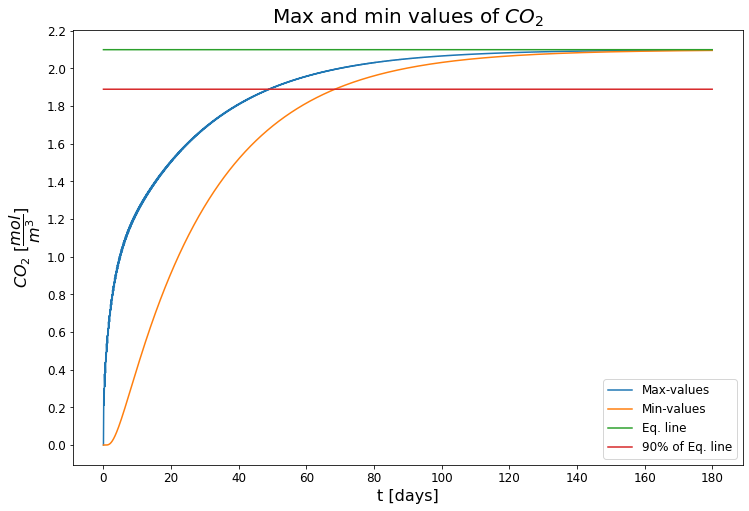

Timestep where the difference has its maxima:  [59]


In [4]:
#Equilibrium, 90% of equilibrium, max and minimum concentrations
Eq_line = np.ones(len(t))*C_eq
Eq_line09 = np.ones(len(t))*C_eq*0.9
high= np.zeros(len(t))
low= np.zeros(len(t))
#Finding the max and min concentrations for each point in time
for i in range(len(t)):
    high[i]=max(C_[i])
    low[i]=min(C_[i])


#Days the simulation will run for
daystep= t/(24*3600)

#Chose units of mol/m3 as we found this to be the most useful
plt.figure(0,figsize=(12,8))
plt.plot(daystep, high, label = f"Max-values")
plt.plot(daystep, low, label = f"Min-values")
plt.plot(daystep, Eq_line,label = f"Eq. line")
plt.plot(daystep, Eq_line09,label = f"90% of Eq. line")
plot("Max and min values of $CO_2$", "t [days]", r"$CO_2$ [$\dfrac{mol}{m^{3}}$]", 12, 10)

plt.legend(loc = "lower right", fontsize ="large")
plt.show()

#Finding the day at which the difference between max and min is largest. 
diff_list= high - low
print("Timestep where the difference has its maxima: " , np.where(diff_list == max(diff_list))[0])







Using the concentration array we plot the concentration as function of depth over a period of $180$ days. This shows a delay, especially for the first third of the simulation, where the minimum concentration(bottom), lags behind the maximum concentration(top). This difference grows smaller as the concentrations get closer to equilibrium.

Both the maxima of the difference and the $90$% of Eq. line are used in later tasks. 



### Task c:

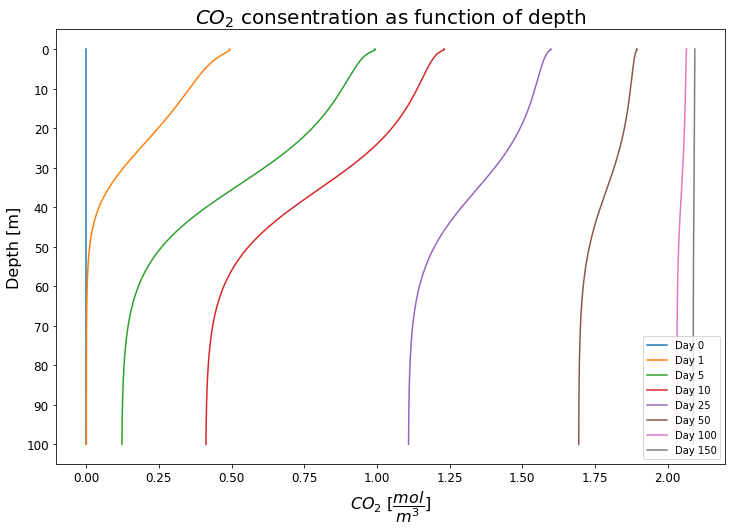

In [5]:
#Plotting one graph for every 10 days in the simulation


plt.figure(1, figsize=(12,8))

shownDays = 10*np.array([0,1,5,10,25,50,100,150])
for i in shownDays:
    plt.plot(C_[i],z, label = f"Day {int(i/10)}")
    

plot("$CO_2$ consentration as function of depth", r"$CO_2$ $[\dfrac{mol}{m^{3}}]$", "Depth [m]", 12, 10)
plt.legend(loc = "lower right")
#Inverting the y-axis to get the surface at the top of the plot
plt.gca().invert_yaxis()

plt.show()


To better see how the $CO_2$-concentrations change, a set of sample points with focus on earlier time-values was chosen. 


Discussing figure 1 we can conclude that it takes roughly 100 days before the oceans concentration 
of $CO_2$ has adapted to the changes in the atmosphere, and from there on it appears uniform down to the depth of $100$ meters.
However, the water nearest the surface changes faster for early time-values, and slower for later values compared to that on the bottom. Half the change in concentration in the 
uppermost meter of water happens within the first ten days of the simulation. At the end of task b, the peak difference between the lowest and highest value of $CO_2$ is shown to happen after 6 days. 










### Task d:


The change in $CO_2$ in the oceans to a depth of $100$m follows the atmospheric change by a slight displacement. 
It takes the ocean approximately $100$ days to reach a uniform distribution from the surface to the sea floor. 
This can be interpreted from the figure calculating maximum and minimum values, 
as the sea floor will be our minimum, and the surface has the highest concentration.
Note also that it takes approximately $50$ days for the surface to reach the $90$% equilibrium line,
and that the seafloor needs $70$ days to reach the same value. They synchronize for the maximum value even though the surface has a higher value. 



However, if "in sync" is interpreted to mean "in phase with" the conclusion differs. Propose that the $CO_2$ levels were to decrease. Given that scenario, the concentration in the ocean would be out of phase by three months and lag behind the atmospheric changes.

If we assume a change like in figure $(3)$ from the assignment, which at all time stays below $2.3$ppm/year and uniformly positive, the earlier discussed phase shift would become harder to see. 

Either way there is a definitive correlation between the amount of $CO_2$ in the atmosphere and the amount at $100$ meters depth.

## Problem 2: $CO_2$ absorption by the deep ocean


When assessing deeper ocean, a different model is needed. An initial concentration of DIC at equilibrium is assumed, and a sigmoid-function is used to describe the diffusivity.
The depth of $4000$ meters is a depth to represent the average depth of the worlds oceans and the timescale is adjusted so that the absorption in the ocean can be measured over several years. The amount of $CO_2$ is not constant in this model, but changes linearly. The task is then to figure out how much the increase of atmospheric $CO_2$ contributes to higher levels of DIC in the ocean.




### Task a:

In [6]:
#Redefinition of essential parameters with respect to problem 2
N2=4000
l2=4000
days2 = 3652 #Approx days in 10 years
kw = 6.97*10**(-5)


t2, dt2 = np.linspace(0, days_in_seconds*days2, days2, retstep = True)
z2, dz2 = np.linspace(0, l2, N2, retstep = True)

#Fetching values for the concentration of carbondioxide in the air
C_atm = ppCO2 + (2.3*10**(-6)*t2)/(365*24*60*60)

C_eq_arr2 = 5060*(C_atm)

#Initial concentration
c02 = np.ones(N2)*C_eq_arr2[0]

#Setting diffusivity for 4000m
K2 = k2(z2)

#Applying new functions and constant to create the matrices needed
alpha2, T2, K_2 = consts(t2, dt2, z2, dz2, kw, K2)
L2, R2, S2 = createMatrices(t2, alpha2, K2, K_2, T2, C_eq_arr2, N2)


#Making our concentration an array with each timestep
C_2 = C_iter(c02, K2, t2, S2, N2, L2, R2)

Worth noting that over a ten-year period, the increase of $CO_2$ in the atmosphere is approximately $5.5$% of its starting value. This is calculated from the steady growth of $2.3$ppm per year over the ten-year period.


### Task b:

Task b contains a plot of the concentration as a function of depth, which provides an intuitive understanding of the amount of carbon dioxide. A plot with only depth down to $1000$ meters is also included for readability.

 

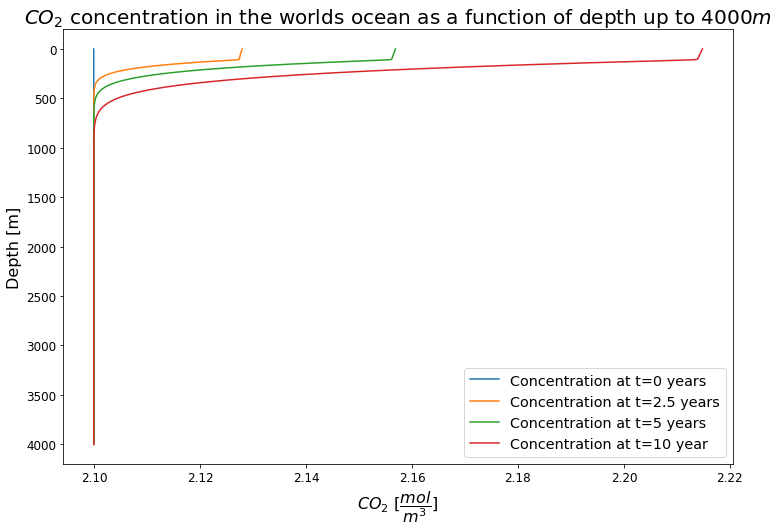

In [7]:
#Plotting the results for depths down to 4000m at four different times as requested in the task.


plt.figure(3,figsize=(12,8))
plt.plot(C_2[0],z2, label = "Concentration at t=0 years")
plt.plot(C_2[911],z2, label = "Concentration at t=2.5 years")
plt.plot(C_2[1825],z2, label = "Concentration at t=5 years")
plt.plot(C_2[3651],z2, label = "Concentration at t=10 year")
plot("$CO_2$ concentration in the worlds ocean as a function of depth up to $4000m$", "$CO_2$ [$\dfrac{mol}{m^{3}}$]","Depth [m]", 16, 12)
plt.gca().invert_yaxis()
plt.legend(loc = "lower right", fontsize = "x-large")

plt.show()

From this plot it is apparent that at great depths the diffusivity is quite small, as predicted from the formula implemented.
When the water depth is greater than $1000$ meters, the $CO_2$ levels are almost unaltered by the increase in air concentration. 
At surface level the increase over ten years is easily comparable to the levels in air, with an increase of approximately $5.4$%.
 


### Plot to depth of 1000m:

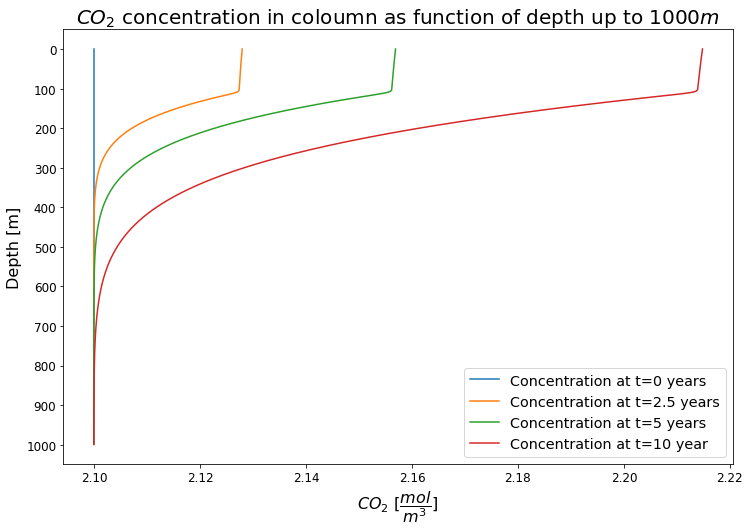

In [8]:
#We chose to include this plot as it more clearly illustrates the increase, 
#seeing as the diffusivity at great depths is very small.
plt.figure(4, figsize=(12,8))

#Slicing the arrays to shorten the depth
C_2_1000m = C_2[:,:1000]
z2_1000m = z2[:1000]

plt.plot(C_2_1000m[0],z2_1000m, label = "Concentration at t=0 years")
plt.plot(C_2_1000m[911],z2_1000m, label = "Concentration at t=2.5 years")
plt.plot(C_2_1000m[1825],z2_1000m, label = "Concentration at t=5 years")
plt.plot(C_2_1000m[3651],z2_1000m, label = "Concentration at t=10 year")
plt.gca().invert_yaxis()
plt.locator_params(nbins=16)
plot("$CO_2$ concentration in coloumn as function of depth up to $1000m$", "$CO_2$ [$\dfrac{mol}{m^{3}}$]", "Depth [m]", 16, 12)
plt.legend(loc = "lower right",fontsize = "x-large")

plt.show()



It seems that in this ten-year period, the concentration at $800$ meters and below is uninfluenced by the atmospheric increase. This originates in our diffusivity equation, and we expect that a more accurate representation might not decrease as rapidly. From Grubers experiment$^{2}$, he argues that $75$% of the anthropogenic $CO_2$ is located at depths smaller than $1000$ meters. As the plot shows, in our simulation, it seems $100$% is located in depths smaller than $750$ meters. 

In light of figure $(2)$ it can be observed that for the first $100$ meters, it seems to be a steady concentration. Observe how that corresponds nicely to the idea that in this mixing layer it exists an equilibrium between the atmospheric and dissolved concentrations. This gives support for viewing the first mixing layer as a reversible process between $CO_2$ and DIC, as the ocean both absorbs and delivers carbon.




### Task c:

For the purpose of finding the total mass, scipy.integrate.simps() is used to integrate along the depth. This results in the carbon mass in a single column, which is multiplied by the given surface area of the oceans.
The resulting amount of moles is multiplied with the molar mass of carbon to obtain the total mass of DIC. 
This will at best serve as a rough approximation. For the final result we chose units of Petagrams ($10^{15}$). 

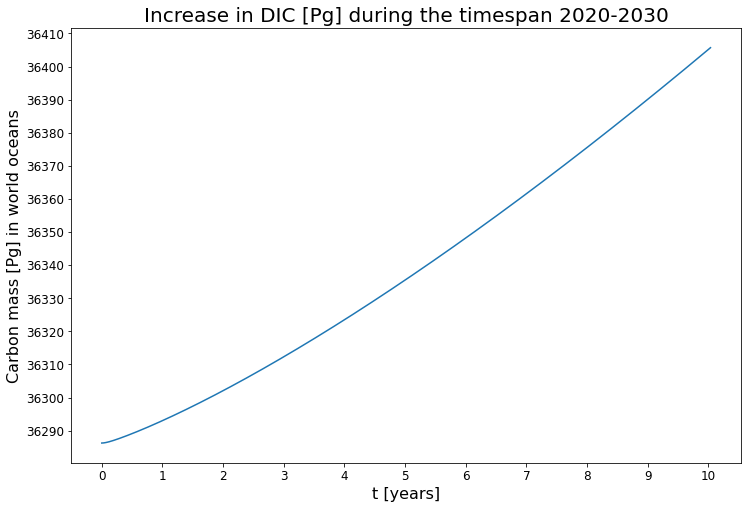

Absorbed DIC in the ocean on average per year during our simulation: 11.94 petagrams
Grubers numbers make up  20.9317 % of what was found from our calculations


In [9]:
#Using molar mass to convert to kilograms per mole

#Making our concentration an array with each timestep


molar_mass_c02 = 12   
#The integrating function used
int_arr_mass = integrate.simps(C_2, x = z2, axis = 1)

mass = int_arr_mass*molar_mass_c02*360*10**(12)

#plotting results
plt.figure(5, figsize = (12, 8))
plt.plot(t2/(364*24*60*60), mass/(10**15)) #Scaling for units of years
plot("Increase in DIC [Pg] during the timespan 2020-2030", "t [years]", "Carbon mass [Pg] in world oceans", 16, 12) 


plt.show()

mass_per_year=(mass[-1]-mass[0])/10


print("Absorbed DIC in the ocean on average per year during our simulation:", f"{np.round(mass_per_year/(10**15),2)} petagrams")

print("Grubers numbers make up ", round(2.5*10**(15)/mass_per_year * 100, 4), "% of what was found from our calculations")


When the mass of DIC in our water column at the start and end is compared we find that on average the ocean absorbs $1.194*10^{16}$ grams more DIC per year than it would with pre-industrial levels.
This is roughly five times what Gruber concluded with. A clear reason as to why our number is higher, is that we have a linear increase in atmospheric $CO_2$ in the timespan from $2020-2030$.
Gruber estimates the change in the period $1994-2007$, and it is reasonable to assume that we are dealing with higher concentrations than what was present during their measurements.
Our result is contrasting by a factor of $4.77$.



Evaluating this is a difficult task. We need to see the results in light of our simplifications and address how they affect the numbers.
Since the ocean is far from uniform, we were presented two different diffusivity models to use for shallow and deep waters.
In this task we calculated the anthropogenic DIC from model two. Comparing the two models, model two gives a significantly higher result than model one for shallow waters.
This might cause our number to have a higher value than Grubers, seeing as he made use of a more complex and detailed model of the ocean.

Even though there is a difference, when considering our simplifications
and assumptions, it is not a bad estimate.

Questions should however be raised as to if our equations are plausible. It is an extreme simplification to compress all our results into a simple PDE, when in reality the oceans are much more complex than what this takes into account.
Another doubtful assumption here is the set of diffusivity equations. Not only do they differ significantly, they also represent a great simplification that does not necessarily produce an accurate result. 
Even though this might be our biggest error source, it is also difficult to evaluate just how this affects our results.

Furthermore we gather from Grubers model that they found the anthropogenic $CO_2$ to be different in some world oceans$^{2}$. This could be due to local winds, or the fact that $CO_2$ is more soluble in colder water. 
We have assumed a constant wind speed and uniform solubility throughout the study. On top of that we had a fixed set of equations for flux and a linear relationship between the partial pressure and concentration. The calculations would without a doubt become different if we were to account for these variations.
In his study the biggest differences they found were lower values than expected. This leads to believe that our number also would be lower if we had gone more in into detail.

Gruber estimates that $75$% of the anthropogenic $CO_2$ is absorbed in the uppermost $1000$ meters$^{2}$. By roughly estimating our graph, it seems that the change in air only affects the concentration above $1000$ meters. 
This could be a result of our simplifications, and possibly caused by our simple one dimensional model since the oceans change in all three dimensions. 

A side note as to why are numbers are higher, could be that Grubers team did not have data for the polar oceans$^{2}$. Consequently we most probably calculated values for a larger amount of water. 

As for our code, it is based upon the simplifications. In itself the code solves the problems satisfactory, but it is also bounded by assumptions. 
We review our code to be accurate and sufficient for its purpose. Hence we conclude that our code is adequate and the inaccuracy does not originate from bad code, but from simplifications. 

Lastly there are a number of chemical and biological factors that have been neglected. Varying pH levels may conflict 
the chemical reaction that form DIC, algae consumption and other biological processes that occur and differ geographically may affect the final result. We will however not address them as we do not possess the required knowledge.



Reflecting on our project we have produced a clear and reasonable model for DIC in the worlds oceans. 
Even though we made a number of assumptions, our results match sufficiently with a more renowned study.

Our plots and code help us better understand our problem and make interpreting the results much easier. It truly shows the sheer power of using code to solve complex problems.

This project has given an, at least introductory, understanding of the process of absorption, dissolution and transport of DIC in world oceans.
We believe this to be presentable to any audience.  

## References
1)
T.Nordam, et al. One-dimensional diffusion model for $CO_2$ absorption in the ocean. Including all sources in this text.

2)
N. Gruber, D. Clement, B. R. Carter, R. A. Feely, S. Van Heuven, M. Hoppema, M. Ishii, R. M. Key, A. Kozyr, S. K. Lauvset, et al. The oceanic sink for anthropogenic CO2 from 1994 to 2007. Science, 363(6432):1193-1199, 2019. https://science.sciencemag.org/content/sci/363/6432/1193.full.pdf

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cf978f46-c67a-40f7-a5dc-0bd7a5ef57c8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>